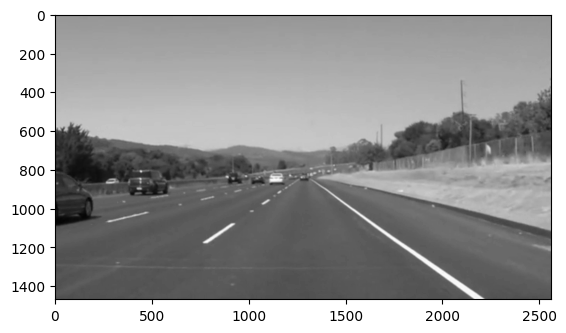

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
 
img = Image.open('./test_img.jpg')# 读取图像
grey_img = np.array(img.convert('L'), dtype=np.int32)# 转为灰度图，再转为numpy数组

plt.imshow(grey_img, cmap='gray')#彩色图转灰度图
plt.show()

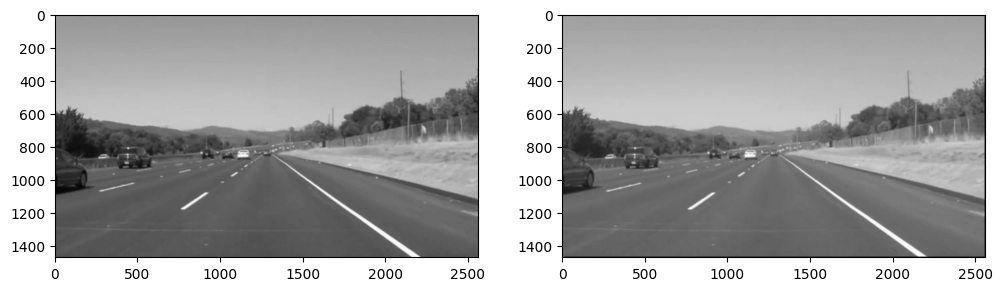

In [33]:
def gaussian_filter(sigma, size):
    middle = (size + 1)/2
    gaussian_function = lambda x,y : (1/(2*np.pi*sigma**2)) * np.exp(-((x**2 + y**2)/(2*sigma**2)))
    gau_filter = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            gau_filter[i][j] = gaussian_function(i-middle+1, j-middle+1)
    return gau_filter / np.sum(gau_filter)

def conv2d(input, kernel, bias=0, stride=1, padding=0):
    # input可以是图像经数组化的二维矩阵，kernel为卷积核本身输入，函数应可计算图像尺寸，改写卷积核，偏置，步长和填充。
    
    # 输入图像和卷积核的维度
    input_height, input_width = input.shape
    kernel_height, kernel_width = kernel.shape

    # 计算输出图像的尺寸
    output_height = int(((input_height - kernel_height + 2 * padding) / stride) + 1)
    output_width = int(((input_width - kernel_width + 2 * padding) / stride) + 1)

    # 创建一个用于存储卷积结果的数组
    output = np.zeros((output_height, output_width))

    # 应用填充
    if padding > 0:
        input = np.pad(input, padding, mode='constant') # 填充常数，默认为0

    # 进行卷积操作
    for i in range(0, input_height - kernel_height + 1, stride):
        for j in range(0, input_width - kernel_width + 1, stride):
            output[i, j] = np.sum(input[i:i+kernel_height, j:j+kernel_width] * kernel) + bias

    return output

def filter(img, kernel):
    process_img = conv2d(img, kernel, 0, 1, 1)

    min_pixel = np.min(process_img)
    max_pixel = np.max(process_img)
    stretched_image = ((process_img - min_pixel) / (max_pixel - min_pixel)) * 255
    stretched_image = stretched_image.astype(np.uint8)  # 转换为0-255之间的整数

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(process_img, cmap='gray')#彩色图转灰度图
    plt.show()
    return process_img

gau_filter = gaussian_filter(0.8, 5)
process_img = filter(grey_img, gau_filter)

# CANNY边缘检测
1. 高斯滤波去噪
2. 计算梯度的幅度与方向
   <div align=left><img src="./images/1.jpg" width="20%" ></img></div>
3. 非极大值抑制，即适当地让边缘“变瘦”。
   1. 获得了梯度的幅度和方向后，遍历图像中的像素点，去除所有非边缘的点：逐一遍历像素点，判断当前像素点是否是周围像素点中具有相同梯度方向的最大值，并根据判断结果决定是否抑制该点
4. 确定边缘，使用双阈值算法确定最终的边缘信息。

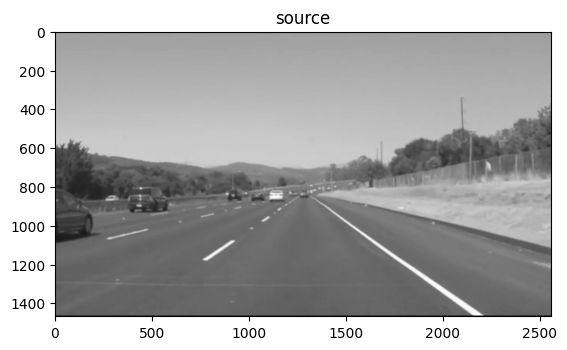

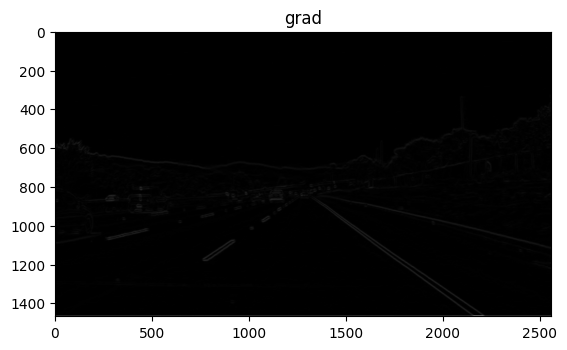

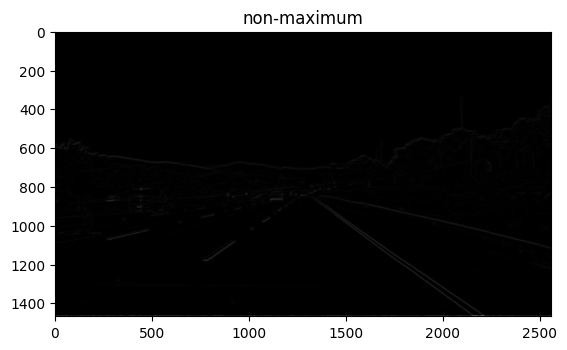

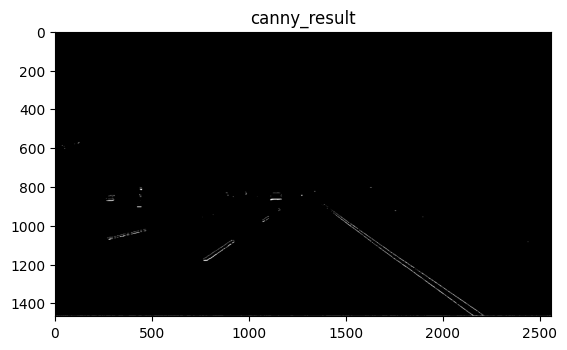

In [40]:
import numpy as np
from matplotlib import pyplot as plt
import math

# 假设 process_img 是一个 NumPy 数组
canny_img1 = np.array(process_img)

plt.figure(1)
plt.title('source')
plt.imshow(canny_img1, cmap='gray')

# 计算梯度
grad_x = np.zeros_like(canny_img1)
grad_y = np.zeros_like(canny_img1)

grad_x[1:-1, 1:-1] = canny_img1[1:-1, 2:] + canny_img1[:-2, 2:] + 2 * canny_img1[1:-1, 1:-1] - \
                    canny_img1[:-2, :-2] - canny_img1[1:-1, :-2] - 2 * canny_img1[:-2, 1:-1]

grad_y[1:-1, 1:-1] = canny_img1[2:, :-2] + canny_img1[2:, 2:] + 2 * canny_img1[2:, 1:-1] - \
                    canny_img1[:-2, :-2] - canny_img1[:-2, 2:] - 2 * canny_img1[:-2, 1:-1]

grad_x = np.floor(grad_x / 4)
grad_y = np.floor(grad_y / 4)

grad_mag = np.floor(np.sqrt(grad_x**2 + grad_y**2))
grad_mag[grad_mag > 255] = 255

grad_dir = np.zeros_like(grad_x)
grad_dir[grad_x == 0] = 2  # y 方向
grad_dir[grad_x != 0] = np.floor(np.arctan2(grad_y[grad_x != 0], grad_x[grad_x != 0]) / (np.pi / 8))
grad_dir[(grad_dir < 0) & (grad_dir >= -3)] += 4  # 将负角度转换为正值

# 显示梯度幅度图
plt.figure(2)
plt.title('grad')
plt.imshow(grad_mag, cmap='gray')

# 非极大值抑制
canny_img2 = grad_mag.copy()

for j in range(1, grad_mag.shape[0] - 1):
    for i in range(1, grad_mag.shape[1] - 1):
        dir = grad_dir[j, i]
        grad_now = grad_mag[j, i]

        if dir == 0 and (grad_now < grad_mag[j, i + 1] or grad_now < grad_mag[j, i - 1]):
            canny_img2[j, i] = 0
        elif dir == 1 and (grad_now < grad_mag[j + 1, i + 1] or grad_now < grad_mag[j - 1, i - 1]):
            canny_img2[j, i] = 0
        elif dir == 2 and (grad_now < grad_mag[j + 1, i] or grad_now < grad_mag[j - 1, i]):
            canny_img2[j, i] = 0
        elif dir == 3 and (grad_now < grad_mag[j + 1, i - 1] or grad_now < grad_mag[j - 1, i + 1]):
            canny_img2[j, i] = 0

# 显示非极大值抑制后的结果
plt.figure(3)
plt.title('non-maximum')
plt.imshow(canny_img2, cmap='gray')

# 双阈值检测
low = 30
high = 60

canny_img2[(canny_img2 >= low) & (canny_img2 <= high)] = 255
canny_img2[canny_img2 < low] = 0

# 显示双阈值检测后的结果
plt.figure(4)
plt.title('canny_result')
plt.imshow(canny_img2, cmap='gray')
plt.show()
